In [1]:
import osmnx as ox
import pandas as pd
import plotly.express as px
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

In [2]:
address = 'Denver County, CO'
#This might require a for loop of the following counties
#Boulder, Broomfield, Denver and Jefferson counties, parts of Adams, Arapahoe and Douglas Counties, and a small portion of Weld County

In [26]:
osm_bridges = ox.geometries_from_address(address, tags = {'bridge': True}, dist=1000) #dist should be 72000

C:\Users\Matucoco\UP_anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\Matucoco\UP_anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\Matucoco\UP_anaconda3\lib\site-packages\pandas\core\algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  commo

In [30]:
#Use this to check which bridges were captured by OSM
#print(osm_bridges)

In [27]:
osm_bridges = osm_bridges.buffer(.0002)

C:\Users\Matucoco\AppData\Local\Temp\ipykernel_9816\878201805.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  osm_bridges = osm_bridges.buffer(.0002)


<Axes: >

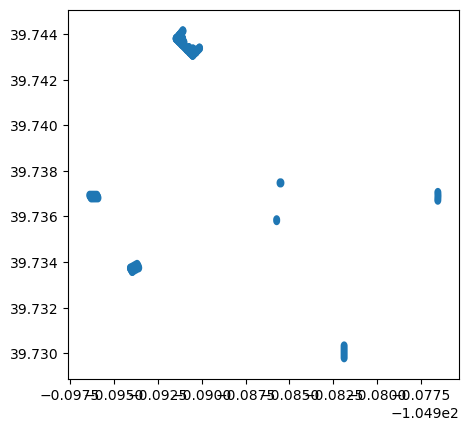

In [28]:
osm_bridges.plot()

In [29]:
#bring in bus routes with bad USGS elevation data
bus_routes= gpd.read_file('shape_routes_elevation.zip')
#bus_routes.head()

,cat,cat_,shape_id,begin,end,shapes_joi,shapes_j_1,length,z_start,z_end,slope,geometry
0,1,1,1252641,1,1078,DASH,1,152.306,1585.819,1586.263,0.003,"LINESTRING Z (492339.825 4426494.121 1585.819,..."
1,2,1,1252641,1,1078,DASH,1,152.306,1586.263,1586.207,-0.000,"LINESTRING Z (492271.428 4426403.240 1586.263,..."
2,3,1,1252641,1,1078,DASH,1,152.306,1586.207,1587.204,0.007,"LINESTRING Z (492206.889 4426316.327 1586.207,..."
3,4,1,1252641,1,1078,DASH,1,152.306,1587.204,1588.533,0.009,"LINESTRING Z (492054.650 4426317.496 1587.204,..."
4,5,1,1252641,1,1078,DASH,1,152.306,1588.533,1590.076,0.010,"LINESTRING Z (491902.411 4426318.850 1588.533,..."


In [38]:
#Check the crs of the bus and bridge data
osm_bridges = osm_bridges.to_crs("EPSG:32613")
print(osm_bridges.crs)
print(bus_routes.crs)

EPSG:32613


In [39]:
def intersects_bridge(row):
    if osm_bridges.contains(bus_routes).any()=1 
        x= 0 
    else x= bus_routes['slope']
    return x

bus_routes['slope'] = df.apply(intersects_bridge, axis=1)

SyntaxError: cannot assign to function call here. Maybe you meant '==' instead of '='? (2722302000.py, line 2)